In [1]:
from MPyDATA.mpdata import MPDATA
from MPyDATA.coord import x_id, x_ln, x_p2
import numpy as np
from scipy import integrate

In [23]:
from matplotlib import pyplot 
%matplotlib inline

import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

tunit = si.second
xunit = si.micrometre
yunit = 1 / si.micrometre / si.centimetre**3
cdfunit = yunit * xunit

rho_w = 1 * si.kilogram / si.decimetre**3
rho_a = 1 * si.kilogram / si.metre**3

def xmgn(x):
    return x.to(xunit).magnitude

def tmgn(t):
    return t.to(tunit).magnitude

def fmgn(fun, unit):
    return lambda x: fun(x * xunit).to(unit).magnitude

def diff(x):
    return np.diff(x.magnitude) * x.units


In [53]:
# Rogers & Yau book
class Rogers_drdt:
    # Rogers and Yau p. 104
    ksi_1 = 68.2 * si.micrometre ** 2 / si.second
    S = 1.05
    ksi = (S - 1) * ksi_1
    
    def __call__(self, r):
        return self.ksi / r

class Rogers_pdf:
    def __init__(self, pdf, t):
        self.t = t
        self.pdf = pdf
        
    def __call__(self, r):
        with np.errstate(invalid='ignore'):
            arg = np.sqrt(r ** 2 - 2 * Rogers_drdt.ksi * self.t)
        return r / arg * self.pdf(arg)
    


In [54]:
# Fair weather cummuli case (East & Marshall 1954)
def EM_pdf(r):
    return (
        (700 * si.micrometre) / r * 
        np.exp(-22 * (np.log10(r / (7 * si.micrometre))**2)) *
        (1 / si.centimetre**3 / si.micrometre)
    )
def EM_cdf(r): 
    return (
        175 * np.sqrt(2 * np.pi / 11) * 
        np.erf(np.sqrt(22) * np.log(r / (7 * si.micrometre))/ np.log(10)) * 
        np.log(10) *
        (1 / si.centimetre**3)
    )

In [55]:
# East 1957 setup
def mixrat(pdf):
    r_min = .1 * si.micrometre
    while not np.isfinite(pdf(r_min).magnitude):
        r_min *= 1.01
    
    I = integrate.quad(
        fmgn(lambda r: pdf(r) * (r)**3, yunit * xunit**3), 
        r_min.to(xunit).magnitude, 
        np.inf
    )[0] * yunit * xunit**4
    return (I * 4/3 * np.pi * rho_w / rho_a).to(si.gram / si.kilogram)

C =  (1 * si.gram / si.kilogram) / mixrat(Rogers_pdf(EM_pdf, 0 * si.second))
E57_pdf = lambda r: C * EM_pdf(r)
E57_cdf = lambda r: C * EM_cdf(r)

class Setup:
    nr = 50
    nt = []
    dt = .01 * si.second
    r_min = 1 * si.micrometre
    r_max = 25 * si.micrometre

    pdf0 = E57_pdf 
    cdf0 = E57_cdf    
    drdt = Rogers_drdt()

    ts = np.array([0, 6.505, 16.384, 38.475]) * si.second
    mixrats = np.array([1, 2, 4, 10]) * si.gram / si.kilogram
    for i, m in enumerate(mixrats):
        np.testing.assert_approx_equal(mixrat(Rogers_pdf(E57_pdf, ts[i])), m, 5) 

    for t in ts:
        nt.append(int((t / dt).to(si.dimensionless).magnitude))

AssertionError: 
Items are not equal to 5 significant digits:
 ACTUAL: 0.0011750100972895085
 DESIRED: 0.002

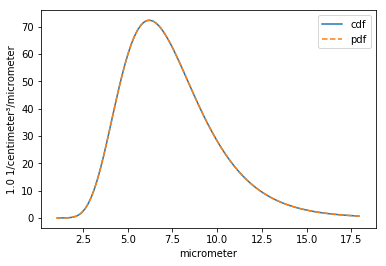

In [27]:
# Fig 3 from East & Marshall 1954
x = np.linspace(1,18,100) * si.micrometre
pyplot.plot(x[1:] - diff(x)/2, diff(Setup.cdf0(x)) / diff(x), label='cdf')
pyplot.plot(x, Setup.pdf0(x), label='pdf', linestyle='--')
pyplot.legend()
pyplot.gca().yaxis.set_units(1/si.centimetre**3/si.micrometre)

In [28]:
def run(setup):
    s = setup
    result = {}
    for fn in (x_id, x_p2, x_ln):
        result[fn] = {}

        algos = (
            MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), 
                   {"n_it": 1, "dfl": 0, "iga": 0, "tot": 0, "fct": 0}),
            MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), 
                   {"n_it": 2, "dfl": 0, "iga": 0, "tot": 0, "fct": 1}),
            MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), 
                   {"n_it":3, "dfl":1, "iga":0, "tot":0, "fct":0}),
            MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), 
                   {"n_it":2, "dfl":0, "iga":1, "tot":1, "fct":1}),
        )

        for algo in algos:
            o = algo.opts
            label = f"n_it={o['n_it']} dfl={o['dfl']} tot={o['tot']} iga={o['iga']} fct={o['fct']}"
            result[fn][label] = {}
    
            nt = 0
            for t in s.nt:
                for _ in range(t - nt):
                    algo.step(fmgn(s.drdt, xunit / tunit))
                nt = t

                # output
                result[fn][label][nt] = {
                    "r": np.copy(algo.state.r), #TODO: redundant
                    "n": np.copy(algo.state.pdf),
                    "rb": np.copy(algo.state.rb)
                }
                
    return result


In [29]:
np.seterr(all='ignore')
data = run(Setup)

In [51]:
class plotter:
    def __init__(self, r_min, r_max, title):
        self.cdfarg, self.dcdfarg = np.linspace(
            r_min,
            r_max,
            512, retstep=True
        )
        self.fig, self.axs = pyplot.subplots(2,1,figsize=(8, 8))

        self.style_dict = {}
        self.style_palette = ['dotted','--', '-', '-.']
        self.axs[0].set_title(title)

    def done(self):
        self.axs[0].xaxis.set_units(si.micrometre)
        self.axs[0].yaxis.set_units(1 / si.micrometre / si.centimetre**3)
        
        self.axs[1].xaxis.set_units(si.micrometre)
        self.axs[1].yaxis.set_units(1 / si.micrometre)

        self.axs[0].grid()
        self.axs[1].grid()
        
        pyplot.legend()
        pyplot.show()

    def pdf_pdf(self, pdf, mnorm):
        x = self.cdfarg
        
        # number distribution
        y = pdf(x)
        self.axs[0].plot(x * xunit, y * yunit, color='red')

        # normalised mass distribution
        y *= yunit * (x * xunit)**3 * 4/3 * np.pi * rho_w / rho_a / mnorm
        self.axs[1].plot(x, y.to_base_units(), color='blue')

    def step(self, xy, label, t):
        lbl = label
        if label not in self.style_dict:
            self.style_dict[label] = self.style_palette[len(self.style_dict)]
        else:
            lbl = ''
            
        # number distribution
        self.axs[0].step(
            xy["r"] * xunit, 
            xy["n"] * yunit, 
            where='mid', label=lbl, linestyle=self.style_dict[label], color='black'
        )

        # normalised mass distribution
        r1 = xy["rb"][:-1] * xunit
        r2 = xy["rb"][1:] * xunit
        
        self.axs[1].step(
            xy["r"] * xunit,
            xy["n"] * yunit * (r2 + r1) * (r2**2 + r1**2)/4 * 4/3 * np.pi * rho_w / rho_a / mnorm,
            where='mid', label=lbl, linestyle=self.style_dict[label], color='black'
        )

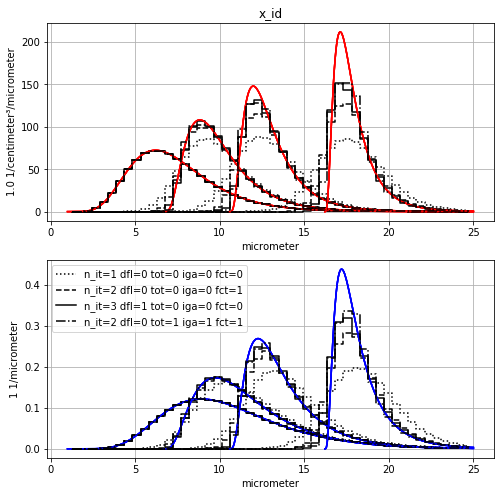

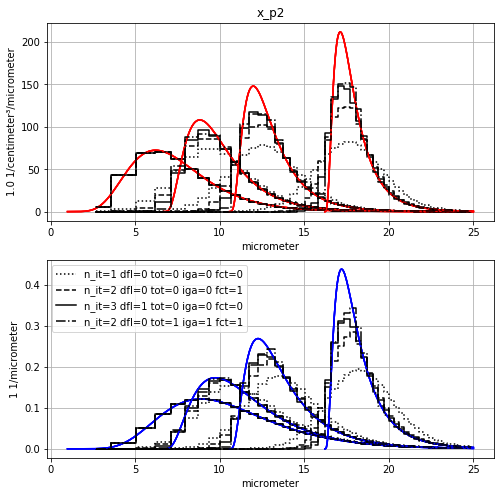

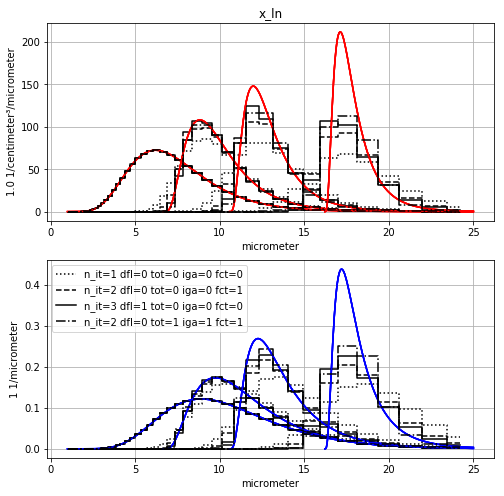

In [52]:
for fn in data:
    plot = plotter(xmgn(Setup.r_min), xmgn(Setup.r_max), fn.__name__)

    for label, ntxy in data[fn].items():
        for nt, xy in ntxy.items():
            mnorm = Setup.mixrats[Setup.nt.index(nt)]
            plot.pdf_pdf(fmgn(Rogers_pdf(E57_pdf, nt * Setup.dt), yunit), mnorm)
            plot.step(xy, label, nt)
    plot.done()